In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import glob
import seaborn as sns

## Read from `~/metrics/epoch_metrics/` directory

In [2]:
df = pd.read_parquet("../../metrics/epoch_metrics/")

# Hyper-Parameters

`bias` `NaN` -> no bias

`bias` $ \in (0, 1)$ -> `bias`% of each client's dataset is biased (from sorted sequence of MNIST) - rest is good

`bias` $= -1$ -> MNIST label 0 is sorted, placed at the start, and clients get assigned sequentially from this dataset. Only one label is biased to however many clients can get it assigned to them.

`bias` $= -2$ -> MNIST label 8 is sorted, placed at the start, and clients get assigned sequentially from this dataset. Only one label is biased to however many clients can get it assigned to them.

In [3]:
one_label_bias = {
    -1: 0,
    -2: 8
}

## All tests summary

Note that this is a summary. 

Notes:
1. `synchronous` method implies `theta` equal to `0.0` and the reverse.
2. The stopping criterion (epochs at the moment) is not the same for all combination, in fact, it changes. For `LeNet-5` currently all tests end at 50 epochs. For the `AdvancedCNN` we go up to 350 epochs in some tests and some others up until 250.
3. `Theta` greater than 2 are exploratory tests and will not be considered at all later on.

In [4]:
df_lenet = df[df['nn_name'] == 'LeNet-5']

In [5]:
for col in ['dataset_name', 'fda_name', 'nn_name', 'num_clients', 'batch_size', 'num_steps_until_rtc_check', 'theta', 'bias']:
    print(f"{col}: {sorted(list(df_lenet[col].unique()))}")

dataset_name: ['MNIST']
fda_name: ['gm', 'linear', 'naive', 'sketch', 'synchronous']
nn_name: ['LeNet-5']
num_clients: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
batch_size: [32, 64, 128, 256]
num_steps_until_rtc_check: [1]
theta: [0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 7.0, 10.0, 12.0, 15.0]
bias: [-2.0, 0.6, nan, -1.0, 0.3, 0.9]


## Query All tests

In [6]:
test_combinations = df.groupby(['dataset_name', 'nn_name', 'fda_name', 'num_steps_until_rtc_check', 'batch_size', 'theta', 'num_clients'])['epoch'].max().reset_index()

In [7]:
test_combinations[
    (test_combinations['nn_name'] == 'AdvancedCNN') &
    (test_combinations['fda_name'] == 'naive') &
    (test_combinations['theta'] == 20.0) &
    (test_combinations['num_clients'] == 5)
]

,dataset_name,nn_name,fda_name,num_steps_until_rtc_check,batch_size,theta,num_clients,epoch
350,MNIST,AdvancedCNN,naive,1,32,20.0,5,100


# Helpful new Dataframe metrics

### Add Helpful Dataset Metrics 

In [8]:
def dataset_n_train(row):
    if row['dataset_name'] == "MNIST":
        return 60_000
    else:
        return -1


def dataset_one_sample_bytes(row):
    if row['dataset_name'] == "MNIST":
        # input image 784 tf.float32 pixels and a tf.int32 label
        return 4 * (784 + 1)
    else:
        return -1

In [9]:
df['n_train'] = df.apply(dataset_n_train, axis=1)
df['one_sample_bytes'] = df.apply(dataset_one_sample_bytes, axis=1)

### Add Helpful model metrics

In [10]:
df['model_bytes'] = df['nn_num_weights'] * 4

### Add Helpful FDA method metrics

In [11]:
def fda_local_state_bytes(row):
    if row['fda_name'] == "naive":
        return 4
    if row['fda_name'] == "linear":
        return 8
    if row['fda_name'] == "sketch":
        return row['sketch_width'] * row['sketch_depth'] * 4 + 4
    if row['fda_name'] == "synchronous":
        return 0
    if row['fda_name'] == 'gm':
        return 0.125  # one bit

In [12]:
df['local_state_bytes'] = df.apply(fda_local_state_bytes, axis=1)

### Add Total Steps

total steps (a single fda step might have many normal SGD steps, batch steps)

In [13]:
df['total_steps'] = df['total_fda_steps'] * df['num_steps_until_rtc_check']

### Add communication metrics

The communication bytes exchanged for model synchronization. Remember that the Clients send their models to the Server and the Server sends the global model back. This happens at the end of every round.

In [14]:
df['model_bytes_exchanged'] = df['total_rounds'] * df['model_bytes'] * df['num_clients'] * 2

The communication bytes exchanged for monitoring the variance. This happens at the end of every FDA step which consists of `num_steps_until_rtc_check` number of steps. 

In [15]:
df['monitoring_bytes_exchanged'] = df['local_state_bytes'] * df['total_fda_steps'] * df['num_clients']

The total communication bytes exchanged in the whole Federated Learning lifecycle.

In [16]:
df['total_communication_bytes'] = df['model_bytes_exchanged'] + df['monitoring_bytes_exchanged']

In [17]:
df['total_communication_gb'] = df['total_communication_bytes'] / 10**9

Add rounds in one epoch.

In [18]:
df = df.sort_values(by=['dataset_name', 'fda_name', 'nn_num_weights', 'num_clients', 'batch_size', 'num_steps_until_rtc_check', 'theta', 'epoch'])

df['epoch_rounds'] = df.groupby(['dataset_name', 'fda_name', 'nn_num_weights', 'num_clients', 'batch_size', 'num_steps_until_rtc_check', 'theta'])['total_rounds'].diff()

# NaN first epoch
df['epoch_rounds'] = df['epoch_rounds'].fillna(df['total_rounds'])

df['epoch_rounds'] = df['epoch_rounds'].astype(int)

# HyperParameter ranking

### LeNet-5
On 2 `Nvidia A10`:
1. Batch Size = 32 -> 6.613 ms ± 0.128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2. *Batch Size* = 64 -> 7.509 ms ± 0.065 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3. *Batch Size* = 128 -> 8.02 ms ± 0.099 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4. *Batch Size* = 256 -> 9.258 ms ± 0.336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

## AdvancedCNN

On 2 `Nvidia A10`:
1. *Batch Size* = 32 -> 8.853 ms ± 0.0917 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2. *Batch Size* = 64 -> 10.325 ms ± 0.215 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3. *Batch Size* = 128 -> 11.989 ms ± 0.134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4. *Batch Size* = 256 -> 16.47 ms ± 0.294 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [19]:
step_ms = {
    ("AdvancedCNN", 32): 8.853,
    ("AdvancedCNN", 64): 10.325,
    ("AdvancedCNN", 128): 11.989,
    ("AdvancedCNN", 256): 16.47,
    ("LeNet-5", 32): 6.613,
    ("LeNet-5", 64): 7.509,
    ("LeNet-5", 128): 8.02,
    ("LeNet-5", 256): 9.258
}

In [20]:
import numpy as np

def cpu_time_cost(row):
    """ Total cpu time cost in (sec).
    A single `step` means each client performed a single `step` 
    """
    return row['total_steps'] * step_ms[(row['nn_name'], row['batch_size'])] / 1000

def communication_time_cost(num_clients, total_communication_bytes, comm_model):
    """ Assuming channel is 1Gbps """

    total_communication_gbit = total_communication_bytes * 8e-9

    if comm_model == 'common_channel':
        
        return ((num_clients - 1) / num_clients) * total_communication_gbit    # sec

    if comm_model == 'hypercube':

        return (np.ceil(np.log(num_clients)) / num_clients) * total_communication_gbit   # sec

In [21]:
df['cpu_time_cost'] = df.apply(cpu_time_cost, axis=1)

In [22]:
df['hypercube_communication_time_cost'] = communication_time_cost(df['num_clients'], df['total_communication_bytes'], 'hypercube')

In [23]:
df['common_channel_communication_time_cost'] = communication_time_cost(df['num_clients'], df['total_communication_bytes'], 'common_channel')

In [24]:
df['hypercube_time_cost'] = df['cpu_time_cost'] + df['hypercube_communication_time_cost']

In [25]:
df['common_channel_time_cost'] = df['cpu_time_cost'] + df['common_channel_communication_time_cost']

In [26]:
df['hypercube_comm_cpu_time_ratio'] = df['hypercube_communication_time_cost'] / df['cpu_time_cost']

In [27]:
df['common_channel_comm_cpu_time_ratio'] = df['common_channel_communication_time_cost'] / df['cpu_time_cost']

# Plots about cost

In [28]:
# Define styles for each fda_name
fda_styles = {
    'naive': 'o-r',
    'linear': 's-g',
    'sketch': '^-b',
    'synchronous': 'x-c'
}
fda_names = ['gm', 'naive', 'linear', 'sketch', 'synchronous']

In [29]:
import matplotlib

num_clients_values = sorted(df['num_clients'].unique())
cmap = matplotlib.colormaps['tab20b']
colors_dict = {
    num_clients: color 
    for num_clients, color in zip(num_clients_values, cmap(np.linspace(0, 1, len(num_clients_values))))
}

## KDE Helper

In [30]:
"""
sns_params = {
    'bw_method': 'scott',
    'bw_adjust': 0.7,
    'fill': True,
    'alpha': 0.2
}
"""
sns_params = {
    'bw_method': 'scott',
    'bw_adjust': 0.7,
    'fill': False,
    'alpha': 1
}

sns_params_biases = {
    'bw_method': 'scott',
    'bw_adjust': 0.7,
    'fill': False,
    'alpha': 0.8
}

base_colors = {
    'gm': 'blue',
    'naive': 'orange',
    'linear': 'green',
    'sketch': 'red',
    'synchronous': 'purple'
}

In [31]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 14

## Total time cost with accuracy

### KDE

In [32]:
def kde_time_cost(df, filename, x_log=True):
    
    if x_log:
        log_scale = (True, False)
    else:
        log_scale = False
        
    plt.rcParams['font.size'] = 20
    plt.rcParams['legend.fontsize'] = 12
    
    pdf = PdfPages(filename)
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        if len(df_bias['fda_name'].unique()) < 2:
            continue
    
        fig, axs = plt.subplots(1, 2, figsize=(20, 8))

        for fda_name in fda_names:
            common_channel_df = df_bias[df_bias['fda_name'] == fda_name]['common_channel_time_cost']
            sns.kdeplot(common_channel_df, label=fda_name, ax=axs[0], color=base_colors[fda_name], log_scale=log_scale, **sns_params)

            hypercube_df = df_bias[df_bias['fda_name'] == fda_name]['hypercube_time_cost']
            sns.kdeplot(hypercube_df, label=fda_name, ax=axs[1], color=base_colors[fda_name], log_scale=log_scale, **sns_params)


        if not x_log:
            axs[0].set_xlim(left=0)
        axs[0].set_xlabel('Time Cost (sec)')
        axs[0].set_ylabel('Density')
        axs[0].legend()
        axs[0].set_title("Common Channel Communication Model")
        axs[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        axs[0].legend()

        if not x_log:
            axs[1].set_xlim(left=0)

        axs[1].set_xlabel('Time Cost (sec)')
        axs[1].set_ylabel('Density')
        axs[1].legend()
        axs[1].set_title("Hypercube Communication Model")
        axs[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        axs[1].legend()
        
        fda_df = df_bias[df_bias['fda_name'] != 'synchronous']
        sync_df = df_bias[df_bias['fda_name'] == 'synchronous']
        info = f"gm, naive, linear, sketch - bs : {fda_df['batch_size'].unique()}  ,  synchronous - bs: {sync_df['batch_size'].unique()}\n"
        fig.suptitle(info+bias_title)
        
        plt.tight_layout()

        pdf.savefig(fig)

        plt.close(fig)
    
        
    pdf.close()
    
    plt.rcParams['font.size'] = 14
    plt.rcParams['legend.fontsize'] = 12

## Total Communication cost (in gb) with accuracy (scatter)

### KDE

In [33]:
def kde_communication_cost(df, filename, x_log=True):

    if x_log:
        log_scale = (True, False)
    else:
        log_scale = False
        
    pdf = PdfPages(filename)
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        if len(df_bias['fda_name'].unique()) < 2:
            continue
    
        plt.figure(figsize=(10, 6))

        avg_communications_dict = {}
        avg_info = []

        for fda_name in fda_names:
            fda_data_df = df_bias[df_bias['fda_name'] == fda_name]['total_communication_gb']
            
            if fda_data_df.empty:
                continue
            
            avg_communications_dict[fda_name] = fda_data_df.mean()
            avg_info.append(f'{fda_name}: {avg_communications_dict[fda_name]:.2f} GB')

            # Plotting only the KDE using kdeplot
            sns.kdeplot(fda_data_df, label=fda_name, log_scale=log_scale, color=base_colors[fda_name], **sns_params)


        text = "Average Communication:\n" + '\n'.join(avg_info)
        # Add the text annotation inside the plot
        plt.text(0.02, 0.97, text, transform=plt.gca().transAxes, fontsize=9, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.4))


        if not x_log:
            plt.xlim(left=0)

        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        plt.xlabel('Communication (GB)')
        plt.ylabel('Density')
        #plt.legend()  # We'll be moving this
        plt.gca().legend(loc='best', bbox_to_anchor=(0, 0.1, 1, 0.67))
        
        fda_df = df_bias[df_bias['fda_name'] != 'synchronous']
        sync_df = df_bias[df_bias['fda_name'] == 'synchronous']
        info = f"gm, naive, linear, sketch - bs : {fda_df['batch_size'].unique()}  ,  synchronous - bs: {sync_df['batch_size'].unique()}\n"
        plt.suptitle(info+bias_title)

        plt.tight_layout()

        pdf.savefig(plt.gcf()) # Save the current figure

        # Close the current figure to prevent it from being displayed in the notebook
        plt.close()
    pdf.close()

## Total CPU time (in Seconds) with accuracy

### KDE

In [34]:
def kde_cpu_time_cost(df, filename, x_log=False):
    
    if x_log:
        log_scale = (True, False)
    else:
        log_scale = False
        
    pdf = PdfPages(filename)
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        if len(df_bias['fda_name'].unique()) < 2:
            continue
    
        plt.figure(figsize=(10, 6))

        for fda_name in fda_names:
            fda_data_df = df_bias[df_bias['fda_name'] == fda_name]['cpu_time_cost']
            
            if fda_data_df.empty:
                continue

            # Plotting only the KDE using kdeplot
            sns.kdeplot(fda_data_df, label=fda_name, log_scale=log_scale, color=base_colors[fda_name], **sns_params)

        if not x_log:
            plt.xlim(left=0)
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        plt.xlabel('CPU time cost (sec)')
        plt.ylabel('Density')
        plt.legend()
        
        fda_df = df_bias[df_bias['fda_name'] != 'synchronous']
        sync_df = df_bias[df_bias['fda_name'] == 'synchronous']
        info = f"gm, naive, linear, sketch - bs : {fda_df['batch_size'].unique()}  ,  synchronous - bs: {sync_df['batch_size'].unique()}\n"
        plt.suptitle(info+bias_title)
        
        plt.tight_layout()

        pdf.savefig(plt.gcf()) # Save the current figure
        
        # Close the current figure to prevent it from being displayed in the notebook
        plt.close()
    pdf.close()

## Total CPU cost / Comm Cost (time) - ratio 

In [35]:
def kde_comm_cpu_time_cost_ratio(df, filename, x_log=True):
    
    if x_log:
        log_scale = (True, False)
    else:
        log_scale = False
        
    plt.rcParams['font.size'] = 20
    plt.rcParams['legend.fontsize'] = 12
    
    pdf = PdfPages(filename)
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        if len(df_bias['fda_name'].unique()) < 2:
            continue
    
        fig, axs = plt.subplots(1, 2, figsize=(20, 8))

        for fda_name in fda_names:
            df_fda = df_bias[df_bias['fda_name'] == fda_name]
            
            if df_fda.empty:
                continue
            
            common_channel_ratio_df = df_fda['cpu_time_cost'] / df_fda['common_channel_communication_time_cost']
            sns.kdeplot(common_channel_ratio_df, label=fda_name, ax=axs[0], color=base_colors[fda_name], log_scale=log_scale, **sns_params)

            hypercube_ratio_df = df_fda['cpu_time_cost'] / df_fda['hypercube_communication_time_cost']
            sns.kdeplot(hypercube_ratio_df, label=fda_name, ax=axs[1], color=base_colors[fda_name], log_scale=log_scale, **sns_params)


        if not x_log:
            axs[0].set_xlim(left=0)
        axs[0].set_xlabel('CPU Time Cost / Comm. Time Cost')
        axs[0].set_ylabel('Density')
        axs[0].legend()
        axs[0].set_title("Common Channel Communication Model")
        axs[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        axs[0].legend()

        if not x_log:
            axs[1].set_xlim(left=0)

        axs[1].set_xlabel('CPU Time Cost / Comm. Time Cost')
        axs[1].set_ylabel('Density')
        axs[1].legend()
        axs[1].set_title("Hypercube Communication Model")
        axs[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        axs[1].legend()
        
        fda_df = df_bias[df_bias['fda_name'] != 'synchronous']
        sync_df = df_bias[df_bias['fda_name'] == 'synchronous']
        info = f"gm, naive, linear, sketch - bs : {fda_df['batch_size'].unique()}  ,  synchronous - bs: {sync_df['batch_size'].unique()}\n"
        fig.suptitle(info+bias_title)
        
        plt.tight_layout()

        pdf.savefig(fig)

        plt.close(fig)
    
        
    pdf.close()
    
    plt.rcParams['font.size'] = 14
    plt.rcParams['legend.fontsize'] = 12

## Keep Hyper-parameters fixed and plot for filtered

In [36]:
def fda_methods_clients_time_cost(df, filename):
    pdf = PdfPages(filename)
    
    batch_size_values = sorted(df['batch_size'].unique())
    theta_values = sorted(df['theta'].unique())[1:]
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            for theta in theta_values:

                filtered_df = df_bias[(df_bias['theta'] == theta) & (df_bias['batch_size'] == batch_size)] 

                if filtered_df.empty:
                    continue

                fig, axs = plt.subplots(1, 2, figsize=(20, 6))

                for fda_name in fda_names:

                    if fda_name == 'synchronous':
                        continue

                    fda_data = filtered_df[filtered_df['fda_name'] == fda_name]

                    if fda_data.empty:
                        continue

                    axs[0].plot(fda_data['num_clients'], fda_data['common_channel_time_cost'], marker='o', color=base_colors[fda_name], label=fda_name, markersize=3)
                    axs[1].plot(fda_data['num_clients'], fda_data['hypercube_time_cost'], marker='o', color=base_colors[fda_name], label=fda_name, markersize=3)

                synchronous_data = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['fda_name'] == 'synchronous')] 

                if not synchronous_data.empty:
                    axs[0].plot(synchronous_data['num_clients'], synchronous_data['common_channel_time_cost'], marker='o', label='synchronous', color=base_colors['synchronous'], markersize=3)
                    axs[1].plot(synchronous_data['num_clients'], synchronous_data['hypercube_time_cost'], marker='o', label='synchronous', color=base_colors['synchronous'], markersize=3)

                if not axs[0].has_data():
                    plt.close(fig)
                    continue

                # Set xticks every 5 units based on available values
                min_clients = 5
                max_clients = 60

                x_ticks = list(range(min_clients, max_clients + 1, 5))

                axs[0].set_yscale('log')
                axs[0].set_xticks(x_ticks)
                axs[0].set_xlabel('Number of clients')
                axs[0].legend()
                axs[0].set_title("Common Channel Communication Model")
                axs[0].set_ylabel('Time Cost')
                axs[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                axs[1].set_yscale('log')
                axs[1].set_xticks(x_ticks)
                axs[1].set_xlabel('Number of clients')
                axs[1].legend()
                axs[1].set_title("Hypercube Communication Model")
                axs[1].set_ylabel('Time Cost')
                axs[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                title = f'Batch Size : {batch_size} , $\Theta$ : {theta} , {bias_title}'
                fig.suptitle(title)

                plt.tight_layout()

                pdf.savefig(fig)

                plt.close(fig)
    pdf.close()

In [37]:
def fda_methods_clients_comm_cost(df, filename):
    pdf = PdfPages(filename)
    
    batch_size_values = sorted(df['batch_size'].unique())
    theta_values = sorted(df['theta'].unique())[1:]
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            for theta in theta_values:

                filtered_df = df_bias[(df_bias['theta'] == theta) & (df_bias['batch_size'] == batch_size)] 

                if filtered_df.empty:
                    continue

                plt.figure(figsize=(10, 6))

                for fda_name in fda_names:

                    if fda_name == 'synchronous':
                        continue

                    fda_data = filtered_df[filtered_df['fda_name'] == fda_name]

                    if fda_data.empty:
                        continue

                    plt.plot(fda_data['num_clients'], fda_data['total_communication_gb'], marker='o', color=base_colors[fda_name], label=fda_name, markersize=3)

                synchronous_data = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['fda_name'] == 'synchronous')] 

                if not synchronous_data.empty:
                    plt.plot(synchronous_data['num_clients'], synchronous_data['total_communication_gb'], marker='o', label='synchronous', color=base_colors['synchronous'], markersize=3)

                # Set xticks every 5 units based on available values
                min_clients = 5
                max_clients = 60

                x_ticks = list(range(min_clients, max_clients + 1, 5))

                plt.yscale('log')
                plt.xticks(x_ticks)
                plt.xlabel('Number of clients')
                plt.legend()
                plt.ylabel('Communication (GB)')
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                title = f'Batch Size : {batch_size} , $\Theta$ : {theta} , {bias_title}'
                plt.suptitle(title)

                plt.tight_layout()

                pdf.savefig(plt.gcf()) # Save the current figure
        
                # Close the current figure to prevent it from being displayed in the notebook
                plt.close()
    pdf.close()

In [38]:
def fda_methods_clients_cpu_cost(df, filename):
    pdf = PdfPages(filename)
    
    batch_size_values = sorted(df['batch_size'].unique())
    theta_values = sorted(df['theta'].unique())[1:]
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]
        
        for batch_size in batch_size_values:
            for theta in theta_values:

                filtered_df = df_bias[(df_bias['theta'] == theta) & (df_bias['batch_size'] == batch_size)] 
                    
                if filtered_df.empty:
                    continue

                plt.figure(figsize=(10, 6))

                for fda_name in fda_names:

                    if fda_name == 'synchronous':
                        continue

                    fda_data = filtered_df[filtered_df['fda_name'] == fda_name]

                    if fda_data.empty:
                        continue

                    plt.plot(fda_data['num_clients'], fda_data['cpu_time_cost'], marker='o', color=base_colors[fda_name], label=fda_name, markersize=3)

                synchronous_data = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['fda_name'] == 'synchronous')] 

                if not synchronous_data.empty:
                    plt.plot(synchronous_data['num_clients'], synchronous_data['cpu_time_cost'], marker='o', label='synchronous', color=base_colors['synchronous'], markersize=3)

                # Set xticks every 5 units based on available values
                min_clients = 5
                max_clients = 60

                x_ticks = list(range(min_clients, max_clients + 1, 5))

                #plt.yscale('log')
                plt.xticks(x_ticks)
                plt.xlabel('Number of clients')
                plt.legend()
                plt.ylabel('CPU Time Cost (sec)')
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                title = f'Batch Size : {batch_size} , $\Theta$ : {theta} , {bias_title}'
                plt.suptitle(title)

                plt.tight_layout()

                pdf.savefig(plt.gcf()) # Save the current figure
        
                # Close the current figure to prevent it from being displayed in the notebook
                plt.close()
    pdf.close()

In [39]:
def fda_methods_theta_time_cost(df, filename):
    pdf = PdfPages(filename)
    
    batch_size_values = sorted(df['batch_size'].unique())
    num_clients_values = sorted(df['num_clients'].unique())
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]

        for batch_size in batch_size_values:
            for num_clients in num_clients_values:

                filtered_df = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['num_clients'] == num_clients)] 

                if filtered_df[filtered_df['fda_name'] != 'synchronous'].empty:
                    continue

                fig, axs = plt.subplots(1, 2, figsize=(20, 6))

                for fda_name in fda_names:

                    if fda_name == 'synchronous':
                        continue

                    fda_data = filtered_df[filtered_df['fda_name'] == fda_name]

                    if fda_data.empty:
                        continue

                    axs[0].plot(fda_data['theta'], fda_data['common_channel_time_cost'], marker='o', label=fda_name, color=base_colors[fda_name], markersize=3)
                    axs[1].plot(fda_data['theta'], fda_data['hypercube_time_cost'], marker='o', label=fda_name, color=base_colors[fda_name], markersize=3)

                synchronous_data = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['fda_name'] == 'synchronous') & (df_bias['num_clients'] == num_clients)] 

                if not synchronous_data.empty:
                    axs[0].axhline(y=synchronous_data['common_channel_time_cost'].iloc[0], label='synchronous', marker='o', color=base_colors['synchronous'], markersize=3)
                    axs[1].axhline(y=synchronous_data['hypercube_time_cost'].iloc[0], label='synchronous', marker='o', color=base_colors['synchronous'], markersize=3)

                if not axs[0].has_data():
                    plt.close(fig)
                    continue

                axs[0].set_yscale('log')
                axs[0].set_xlabel('Theta')
                axs[0].legend()
                axs[0].set_title("Common Channel Communication Model")
                axs[0].set_ylabel('Time Cost')
                axs[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                axs[1].set_yscale('log')
                axs[1].set_xlabel('Theta')
                axs[1].legend()
                axs[1].set_title("Hypercube Communication Model")
                axs[1].set_ylabel('Time Cost')
                axs[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                title = f'Batch Size : {batch_size} , Num Clients : {num_clients} , {bias_title}'
                fig.suptitle(title)

                plt.tight_layout()

                pdf.savefig(fig)

                plt.close(fig)
    pdf.close()

In [40]:
def fda_methods_theta_comm_cost(df, filename):
    pdf = PdfPages(filename)
    
    batch_size_values = sorted(df['batch_size'].unique())
    num_clients_values = sorted(df['num_clients'].unique())
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]

        for batch_size in batch_size_values:
            for num_clients in num_clients_values:

                filtered_df = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['num_clients'] == num_clients)] 

                if filtered_df[filtered_df['fda_name'] != 'synchronous'].empty:
                    continue

                plt.figure(figsize=(10, 6))

                for fda_name in fda_names:

                    if fda_name == 'synchronous':
                        continue

                    fda_data = filtered_df[filtered_df['fda_name'] == fda_name]

                    if fda_data.empty:
                        continue

                    plt.plot(fda_data['theta'], fda_data['total_communication_gb'], marker='o', label=fda_name, color=base_colors[fda_name], markersize=3)

                synchronous_data = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['fda_name'] == 'synchronous') & (df_bias['num_clients'] == num_clients)] 

                if not synchronous_data.empty:
                    plt.axhline(y=synchronous_data['total_communication_gb'].iloc[0], label='synchronous', marker='o', color=base_colors['synchronous'], markersize=3)

                plt.yscale('log')
                plt.xlabel('Theta')
                plt.legend()
                plt.ylabel('Communication Cost (GB)')
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                title = f'Batch Size : {batch_size} , Num Clients : {num_clients} , {bias_title}'
                plt.suptitle(title)

                plt.tight_layout()

                pdf.savefig(plt.gcf())

                plt.close()
    pdf.close()

In [41]:
def fda_methods_theta_cpu_cost(df, filename):
    pdf = PdfPages(filename)
    
    batch_size_values = sorted(df['batch_size'].unique())
    num_clients_values = sorted(df['num_clients'].unique())
    
    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    for bias in biases:
        
        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'
            
        df_bias = df[mask]

        for batch_size in batch_size_values:
            for num_clients in num_clients_values:

                filtered_df = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['num_clients'] == num_clients)] 

                if filtered_df[filtered_df['fda_name'] != 'synchronous'].empty:
                    continue

                plt.figure(figsize=(10, 6))

                for fda_name in fda_names:

                    if fda_name == 'synchronous':
                        continue

                    fda_data = filtered_df[filtered_df['fda_name'] == fda_name]

                    if fda_data.empty:
                        continue

                    plt.plot(fda_data['theta'], fda_data['cpu_time_cost'], marker='o', label=fda_name, color=base_colors[fda_name], markersize=3)

                synchronous_data = df_bias[(df_bias['batch_size'] == batch_size) & (df_bias['fda_name'] == 'synchronous') & (df_bias['num_clients'] == num_clients)] 

                if not synchronous_data.empty:
                    plt.axhline(y=synchronous_data['cpu_time_cost'].iloc[0], label='synchronous', marker='o', color=base_colors['synchronous'], markersize=3)

                #plt.yscale('log')
                plt.xlabel('Theta')
                plt.legend()
                plt.ylabel('CPU Time Cost (sec)')
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                title = f'Batch Size : {batch_size} , Num Clients : {num_clients} , {bias_title}'
                plt.suptitle(title)

                plt.tight_layout()

                pdf.savefig(plt.gcf())

                plt.close()
    pdf.close()

# Per accuracy

In [61]:
def accuracies_plots(df, filename, accuracies):
    pdf = PdfPages(filename)
    
    theta_values = sorted(df['theta'].unique())[1:]

    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    clients = list(range(5, 60 + 1, 5))
    
    batch_sizes = df['batch_size'].unique()

    cmap = matplotlib.colormaps['tab20b']
    colors_dict = {
        num_clients: color 
        for num_clients, color in zip(clients, cmap(np.linspace(0, 1, len(num_clients_values))))
    }

    for bias in biases:

        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'

        df_bias = df[mask]
        
        # 1. Synchronous ALL
        
        df_sync = df_bias[df_bias['fda_name'] == 'synchronous']
        
        for bs in sorted(df_sync['batch_size'].unique()):
            
            bs_df = df_sync[df_sync['batch_size'] == bs]

            dataframes_for_acc = []

            plt.figure(figsize=(10, 6))

            for acc in accuracies:

                filtered_df = bs_df[(bs_df.accuracy > acc)]
                idx = filtered_df.groupby(['fda_name', 'num_clients', 'batch_size', 'theta', 'bias'], dropna=False)['epoch'].idxmin()
                filtered_df = filtered_df.loc[idx]

                dataframes_for_acc.append(filtered_df)

            df_concat = pd.concat(dataframes_for_acc)

            for num_clients in clients:
                client_df = df_concat[df_concat['num_clients'] == num_clients]

                plt.plot(client_df['accuracy'], client_df['total_communication_gb'], marker='o', color=colors_dict[num_clients], label=num_clients, markersize=3)

            if df_concat.empty:
                plt.close()
                continue

            plt.yscale('log')
            plt.xlabel('Accuracy')
            plt.legend()
            plt.ylabel('Communication Cost (GB)')
            plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

            title = f'Batch Size : {bs} , {bias_title}'
            plt.title(title)
            plt.suptitle('synchronous')

            pdf.savefig(plt.gcf())

            plt.close()

        #plt.figure(figsize=(10, 6))
        
        not_sync_df = df_bias[df_bias['fda_name'] != 'synchronous']

        for theta in theta_values:
            theta_df = not_sync_df[not_sync_df['theta'] == theta]
            
            for bs in sorted(theta_df['batch_size'].unique()):
                bs_df = theta_df[theta_df['batch_size'] == bs]

                for fda_name in fda_names:

                    fda_df = bs_df[bs_df['fda_name'] == fda_name]

                    dataframes_for_acc = []

                    plt.figure(figsize=(10, 6))

                    for acc in accuracies:

                        filtered_df = fda_df[(fda_df.accuracy > acc)]
                        idx = filtered_df.groupby(['fda_name', 'num_clients', 'batch_size', 'theta', 'bias'], dropna=False)['epoch'].idxmin()
                        filtered_df = filtered_df.loc[idx]

                        dataframes_for_acc.append(filtered_df)

                    df_concat = pd.concat(dataframes_for_acc)

                    for num_clients in clients:
                        client_df = df_concat[df_concat['num_clients'] == num_clients]

                        plt.plot(client_df['accuracy'], client_df['total_communication_gb'], marker='o', color=colors_dict[num_clients], label=num_clients, markersize=3)

                    if df_concat.empty:
                        plt.close()
                        continue

                    plt.yscale('log')
                    plt.xlabel('Accuracy')
                    plt.legend()
                    plt.ylabel('Communication Cost (GB)')
                    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                    title = f'$Theta$ : {theta} , Batch Size: {bs} , {bias_title}'
                    plt.title(title)
                    plt.suptitle(fda_name)

                    pdf.savefig(plt.gcf())

                    plt.close()
    pdf.close()

In [72]:
def accuracies_plots_syncs(df, filename, accuracies):
    pdf = PdfPages(filename)
    
    theta_values = sorted(df['theta'].unique())[1:]

    biases = sorted(df['bias'].unique(), reverse=True)[::-1]

    clients = list(range(5, 60 + 1, 5))
    
    batch_sizes = df['batch_size'].unique()

    cmap = matplotlib.colormaps['tab20b']
    colors_dict = {
        num_clients: color 
        for num_clients, color in zip(clients, cmap(np.linspace(0, 1, len(num_clients_values))))
    }

    for bias in biases:

        if pd.isna(bias):
            mask = df['bias'].isna()
            bias_title = f'Bias: {bias}'
        elif bias > 0:
            mask = df['bias'] == bias
            bias_title = f'Bias: {bias}'
        else:
            mask = df['bias'] == bias
            bias_title = f'Bias: only label {one_label_bias[bias]}'

        df_bias = df[mask]
        
        # 1. Synchronous ALL
        
        df_sync = df_bias[df_bias['fda_name'] == 'synchronous']
        
        for bs in sorted(df_sync['batch_size'].unique()):
            
            bs_df = df_sync[df_sync['batch_size'] == bs]

            dataframes_for_acc = []

            plt.figure(figsize=(10, 6))

            for acc in accuracies:

                filtered_df = bs_df[(bs_df.accuracy > acc)]
                idx = filtered_df.groupby(['fda_name', 'num_clients', 'batch_size', 'theta', 'bias'], dropna=False)['epoch'].idxmin()
                filtered_df = filtered_df.loc[idx]

                dataframes_for_acc.append(filtered_df)

            df_concat = pd.concat(dataframes_for_acc)

            for num_clients in clients:
                client_df = df_concat[df_concat['num_clients'] == num_clients]

                plt.plot(client_df['accuracy'], client_df['total_rounds'], marker='o', color=colors_dict[num_clients], label=num_clients, markersize=3)

            if df_concat.empty:
                plt.close()
                continue

            plt.yscale('log')
            plt.xlabel('Accuracy')
            plt.legend()
            plt.ylabel('Rounds')
            plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

            title = f'Batch Size : {bs} , {bias_title}'
            plt.title(title)
            plt.suptitle('synchronous')

            pdf.savefig(plt.gcf())

            plt.close()

        #plt.figure(figsize=(10, 6))
        
        not_sync_df = df_bias[df_bias['fda_name'] != 'synchronous']

        for theta in theta_values:
            theta_df = not_sync_df[not_sync_df['theta'] == theta]
            
            for bs in sorted(theta_df['batch_size'].unique()):
                bs_df = theta_df[theta_df['batch_size'] == bs]

                for fda_name in fda_names:

                    fda_df = bs_df[bs_df['fda_name'] == fda_name]

                    dataframes_for_acc = []

                    plt.figure(figsize=(10, 6))

                    for acc in accuracies:

                        filtered_df = fda_df[(fda_df.accuracy > acc)]
                        idx = filtered_df.groupby(['fda_name', 'num_clients', 'batch_size', 'theta', 'bias'], dropna=False)['epoch'].idxmin()
                        filtered_df = filtered_df.loc[idx]

                        dataframes_for_acc.append(filtered_df)

                    df_concat = pd.concat(dataframes_for_acc)

                    for num_clients in clients:
                        client_df = df_concat[df_concat['num_clients'] == num_clients]

                        plt.plot(client_df['accuracy'], client_df['total_rounds'], marker='o', color=colors_dict[num_clients], label=num_clients, markersize=3)

                    if df_concat.empty:
                        plt.close()
                        continue

                    plt.yscale('log')
                    plt.xlabel('Accuracy')
                    plt.legend()
                    plt.ylabel('Synchronizations')
                    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

                    title = f'$Theta$ : {theta} , Batch Size: {bs} , {bias_title}'
                    plt.title(title)
                    plt.suptitle(fda_name)

                    pdf.savefig(plt.gcf())

                    plt.close()
    pdf.close()

# Help-Stat

In [43]:
def explore_top(df, acc_thresh, nn_name, fda_name):
    acceptable_acc_df = df[(df.accuracy > acc_thresh) & (df.nn_name == nn_name)]
    acceptable_acc_df = acceptable_acc_df[acceptable_acc_df['fda_name'] == fda_name]
    idx = acceptable_acc_df.groupby(['fda_name', 'num_clients', 'bias', 'batch_size', 'theta'], dropna=False)['epoch'].idxmin()
    filtered_acceptable_acc_df = acceptable_acc_df.loc[idx]
    return filtered_acceptable_acc_df[['num_clients', 'batch_size', 'theta', 'bias', 'total_rounds', 'total_fda_steps', 'epoch', 'total_communication_gb', 'cpu_time_cost', 'hypercube_time_cost', 'common_channel_time_cost']].sort_values(by='common_channel_time_cost')

## Save all those time-cost plots

In [44]:
import os

def time_cost_plots(df, acc_threshold, nn_name, limit_x_axis=False, show_runs=False, params=False, kde_time_log=True, kde_comm_log=True, kde_cpu_log=False):
    # Filter out based on `acc_threshold`
    df_nn = df[(df.nn_name == nn_name)]
    
    acceptable_acc_df = df_nn[(df_nn.accuracy > acc_threshold)]
    
    str_thresh = str(acc_threshold).replace('.', '_')  # replace '.'
    
    if not os.path.exists(f"../../metrics/plots/{nn_name}/{str_thresh}"):
        os.makedirs(f"../../metrics/plots/{nn_name}/{str_thresh}")
        
    # 1. Same runs not included
    
    # 2. Filter out same runs. We choose the instance which first hits the `acc_threshold`
    idx = acceptable_acc_df.groupby(['fda_name', 'num_clients', 'batch_size', 'theta', 'bias'], dropna=False)['epoch'].idxmin()
    filtered_acceptable_acc_df = acceptable_acc_df.loc[idx]
    
    kde_time_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/time_cost.pdf", x_log=kde_time_log)
    
    kde_communication_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/comm_cost.pdf", x_log=kde_comm_log)
    
    kde_cpu_time_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/cpu_cost.pdf", x_log=kde_cpu_log)
    
    kde_comm_cpu_time_cost_ratio(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/ratio.pdf", x_log=kde_comm_log)
    
    # Parameters fixed, and plot
    if params:
        fda_methods_clients_time_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/clients_time_cost.pdf")
        fda_methods_clients_comm_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/clients_comm_cost.pdf")
        fda_methods_clients_cpu_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/clients_cpu_cost.pdf")
        
        fda_methods_theta_time_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/theta_time_cost.pdf")
        fda_methods_theta_comm_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/theta_comm_cost.pdf")
        fda_methods_theta_cpu_cost(filtered_acceptable_acc_df, f"../../metrics/plots/{nn_name}/{str_thresh}/theta_cpu_cost.pdf")
        
    accuracies_plots(df_nn, f"../../metrics/plots/{nn_name}/{str_thresh}/accuracies.pdf")

In [48]:
df_32 = df[
    (df['batch_size'] == 32) | (df['fda_name'] == 'synchronous')
]

In [49]:
df_theta = df[
    (df['theta'] >= 15.) | (df['fda_name'] == 'synchronous')
]

## AdvancedCNN

In [50]:
time_cost_plots(df_theta, 0.99, 'AdvancedCNN', params=True)
time_cost_plots(df_theta, 0.993, 'AdvancedCNN', params=True)
time_cost_plots(df_theta, 0.995, 'AdvancedCNN', params=True)

KeyboardInterrupt: 

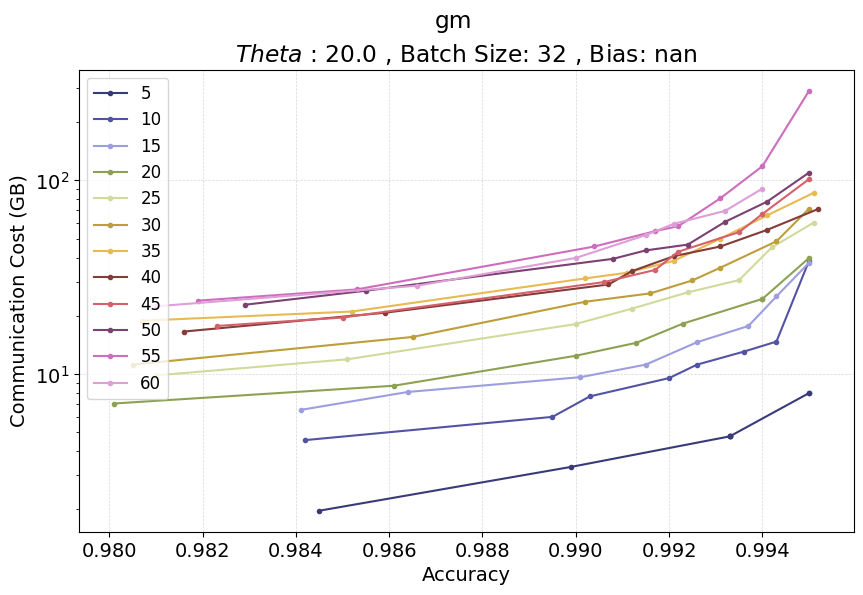

In [70]:
accuracies_plots(df_theta[df_theta['nn_name'] == 'AdvancedCNN'], f"../../metrics/plots/AdvancedCNN/accuracies.pdf", accuracies=[0.98, 0.985, 0.99, 0.991, 0.992, 0.993, 0.994, 0.995])

In [71]:
accuracies_plots_syncs(df_theta[df_theta['nn_name'] == 'AdvancedCNN'], f"../../metrics/plots/AdvancedCNN/syncs.pdf", accuracies=[0.98, 0.985, 0.99, 0.991, 0.992, 0.993, 0.994, 0.995])

## LeNet-5

In [51]:
#explore_top(df, 0.98, 'LeNet-5', 'linear')

In [52]:
time_cost_plots(df_32, 0.98, 'LeNet-5', params=True)
time_cost_plots(df_32, 0.975, 'LeNet-5', params=True)
time_cost_plots(df_32, 0.985, 'LeNet-5', params=True)

In [59]:
accuracies_plots(df_32[df_32['nn_name'] == 'LeNet-5'], f"../../metrics/plots/LeNet-5/accuracies.pdf", accuracies=[0.95, 0.965, 0.96, 0.965, 0.98, 0.985])

In [67]:
accuracies_plots_syncs(df_32[df_32['nn_name'] == 'LeNet-5'], f"../../metrics/plots/LeNet-5/syncs.pdf", accuracies=[0.95, 0.965, 0.96, 0.965, 0.98, 0.985])

In [56]:
df_theta.columns

Index(['dataset_name', 'bias', 'fda_name', 'num_clients', 'batch_size',
       'num_steps_until_rtc_check', 'theta', 'nn_name', 'nn_num_weights',
       'sketch_width', 'sketch_depth', 'epoch', 'total_rounds',
       'total_fda_steps', 'accuracy', 'n_train', 'one_sample_bytes',
       'model_bytes', 'local_state_bytes', 'total_steps',
       'model_bytes_exchanged', 'monitoring_bytes_exchanged',
       'total_communication_bytes', 'total_communication_gb', 'epoch_rounds',
       'cpu_time_cost', 'hypercube_communication_time_cost',
       'common_channel_communication_time_cost', 'hypercube_time_cost',
       'common_channel_time_cost', 'hypercube_comm_cpu_time_ratio',
       'common_channel_comm_cpu_time_ratio'],
      dtype='object')